## Tokenizer Analysis on the BooksCorpus dataset 

After training a tokenizer, we want to see if there are still many [UNK] tokens that show up when tokenizing the data (which will tell us we need to increase vocab size), and also see what the dsitribution of token length is like. This will tell us if 512 is too short for max seq length. 


In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import polars as pl
from transformers import PreTrainedTokenizerFast
from datasets import Dataset 


/home/w/weiyong/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# -------------------
# Utility functions
# -------------------
def clean_text(text):
    # Remove unnecessary symbols (keep punctuation)
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\- ]+", " ", text)
    # Normalize white space
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

def filter_text(text: str, min_length: int = 10, max_length: int = 10000) -> bool:
    """Filter text based on length criteria."""
    if not isinstance(text, str):
        return False
    text_length = len(text.strip())
    return min_length <= text_length <= max_length

# -------------------
# Load dataset & tokenizer
# -------------------
data_path = os.path.expanduser("~/datasets/BookCorpus/BookCorpus3.csv")
df = pl.read_csv(data_path)   # Assume there is a "text" column
tokenizer_path = "../bpe_tokenizer_with_special"
hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)



In [3]:
print("Special tokens:", hf_tokenizer.all_special_tokens)
print("Special token IDs:", hf_tokenizer.all_special_ids)


Special tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
Special token IDs: [1, 3, 0, 2, 4]


In [4]:
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
import numpy as np
from tqdm import tqdm
from datasets.utils.logging import set_verbosity_info
set_verbosity_info()



chunks = []
batch_size = 100_000

for i in tqdm(range(0, df.height, batch_size), desc="Processing chunks"):
    chunk = df[i: i + batch_size]
    chunk = (
        chunk.with_columns([
            pl.col('0').map_elements(clean_text, return_dtype=pl.Utf8).alias("cleaned_text")
        ])
        .filter(
            (pl.col("cleaned_text").str.len_chars() >= 10) &
            (pl.col("cleaned_text").str.len_chars() <= 10000) &
            (pl.col("cleaned_text") != "")
        )
    )
    chunks.append(chunk)

df_processed = pl.concat(chunks)


Processing chunks: 100%|██████████| 111/111 [06:22<00:00,  3.45s/it]


In [5]:
def data_generator():
    for row in df_processed.iter_rows(named=True):
        yield {"cleaned_text": row["cleaned_text"]}

hf_dataset = Dataset.from_generator(data_generator)
hf_dataset.save_to_disk("BookCorpus_cleaned_hf")

Using custom data configuration default-cf4df5e094bc9fcc
Generating dataset generator (/home/w/weiyong/.cache/huggingface/datasets/generator/default-cf4df5e094bc9fcc/0.0.0)
Generating train split
Generating train split: 11040073 examples [00:57, 190485.02 examples/s]
Unable to verify splits sizes.
Dataset generator downloaded and prepared to /home/w/weiyong/.cache/huggingface/datasets/generator/default-cf4df5e094bc9fcc/0.0.0. Subsequent calls will reuse this data.
Saving the dataset (10/10 shards): 100%|██████████| 11040073/11040073 [00:14<00:00, 751639.31 examples/s] 


In [8]:
from datasets import load_from_disk


unk_token_id = hf_tokenizer.unk_token_id
# Function for stats
def analyze_batch(batch):
    encodings = hf_tokenizer(batch["cleaned_text"], padding=False, truncation=False)
    lengths = [len(ids) for ids in encodings["input_ids"]]
    unk_counts = [sum(1 for i in ids if i == unk_token_id) for ids in encodings["input_ids"]]
    return {"lengths": lengths, "unk_counts": unk_counts}



pt_data = load_from_disk("BookCorpus_cleaned_hf")

In [10]:
stats_data = pt_data.map(analyze_batch, batched=True, batch_size=512)


Caching processed dataset at /home/w/weiyong/CS3244/preprocessing/BookCorpus_cleaned_hf/cache-82058cc717add2f7.arrow
Map: 100%|██████████| 11040073/11040073 [15:32<00:00, 11839.57 examples/s]


In [27]:
print(stats_data[:20])


{'cleaned_text': ["she began getting up first thing in the morning. she wanted to avoid konnor and his irrational fear at having her leave him alone in the house. she'd fix a quick bite to eat for both of them, leave konnor's on the table, and then she went to dress for the day.", "caitrin hid the fact that she was a woman behind bulky clothes. her jeans were loose. she tucked the cuffs into the expensive hiking boots she had obtained during a smash and grab at an outdoor store's window display.", 'she considered strapping down her breasts, and decided against it. a sports bra would have to do. overtop of that went a t shirt and a regular shirt. she added an oversize hoodie. beneath that, a ball cap covered the long hair she kept in a bun whenever she went outside.', 'as hard as it had been for caitrin to convince konnor to let her go, he never seemed to notice her disappearance on those twice weekly excursions. perhaps it was because she went quietly out the door. she stopped saying g

1105it [00:26, 42.14it/s]                          


Five Summary Statistics (Token Lengths):
Min: 2
Q1: 57
Median: 75
Q3: 105
Max: 5345


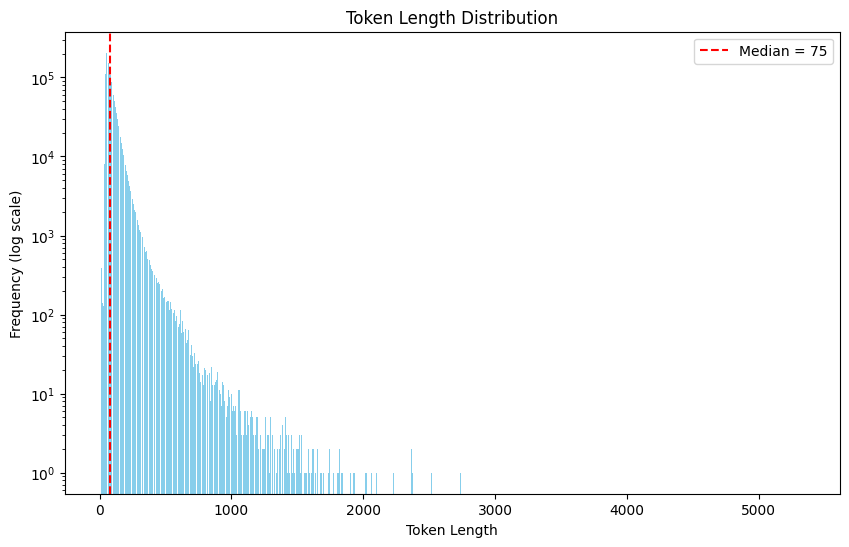

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
length_hist = Counter()

for batch in tqdm(stats_data.iter(batch_size=10000), total=len(stats_data)//10000):
    for l in batch["lengths"]:
        length_hist[int(l)] += 1

# Convert histogram to arrays
lengths, counts = zip(*sorted(length_hist.items()))
lengths = np.array(lengths)
counts = np.array(counts)

# Compute cumulative distribution
cum_counts = np.cumsum(counts)
total = cum_counts[-1]

def percentile(p):
    idx = np.searchsorted(cum_counts, total * p / 100)
    return lengths[idx]

min_len = lengths[0]
q1 = percentile(25)
median = percentile(50)
q3 = percentile(75)
max_len = lengths[-1]

print("Five Summary Statistics (Token Lengths):")
print(f"Min: {min_len}")
print(f"Q1: {q1}")
print(f"Median: {median}")
print(f"Q3: {q3}")
print(f"Max: {max_len}")

# Plot histogram (log scale)
plt.figure(figsize=(10, 6))
plt.bar(lengths, counts, color="skyblue")
plt.yscale("log")
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency (log scale)")
plt.axvline(median, color="red", linestyle="--", label=f"Median = {median}")
plt.legend()
plt.show()


In [28]:
import numpy as np
from tqdm import tqdm

total_unk = 0
total_samples = 0

for batch in tqdm(stats_data.iter(batch_size=10000), total=len(stats_data)//10000):
    batch_unk = np.array(batch["unk_counts"], dtype=np.int32)
    total_unk += batch_unk.sum()
    total_samples += len(batch_unk)

print(f"Total [UNK] tokens: {total_unk}")
print(f"Average [UNK] tokens per sample: {total_unk / total_samples:.2f}")


1105it [00:23, 47.50it/s]                          

Total [UNK] tokens: 0
Average [UNK] tokens per sample: 0.00


In [29]:
from datasets import load_from_disk

dataset = load_from_disk("BookCorpus_cleaned_hf")
print(dataset)

Dataset({
    features: ['cleaned_text'],
    num_rows: 11040073
})


In [32]:
dataset['cleaned_text'][0]

"she began getting up first thing in the morning. she wanted to avoid konnor and his irrational fear at having her leave him alone in the house. she'd fix a quick bite to eat for both of them, leave konnor's on the table, and then she went to dress for the day."